In [11]:
import qdrant_client
from qdrant_client.models import Distance, VectorParams, PointStruct, Filter, FieldCondition, MatchValue, PayloadField
from transformers import AlignProcessor, AlignModel
from PIL import Image
from util import *
import os

In [12]:
qdrant_url = "http://localhost:6333"
client = qdrant_client.QdrantClient(qdrant_url)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AlignProcessor.from_pretrained("kakaobrain/align-base")
model = AlignModel.from_pretrained("kakaobrain/align-base")
model.to(device)

#load_model(model, get_model_path())
model.eval()

AlignModel(
  (text_model): AlignTextModel(
    (embeddings): AlignTextEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlignTextEncoder(
      (layer): ModuleList(
        (0-11): 12 x AlignTextLayer(
          (attention): AlignTextAttention(
            (self): AlignTextSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): AlignTextSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [14]:
def align_image(image_path):
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        output = model.get_image_features(**inputs)
    return output.cpu().numpy()


def align_text(text):
    inputs = processor(text=text, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        output = model.get_text_features(**inputs)
    return output.cpu().numpy()

In [15]:
points = []
index = 0
collection_name = "skin_diseases_align"

In [16]:
# Embedding descriptions
skin_descriptions = get_disease_skin_symptoms()
disease_desriptions = get_disease_descriptions()

for key in skin_descriptions.keys():
    text_embedding = align_text(skin_descriptions[key])
    points.append(
        PointStruct(
            id=index,
            vector=text_embedding.flatten().tolist(),
            payload={
                "label": key,
                "original_text": disease_desriptions[key],
                "type": "text",
            },
        )
    )

    index += 1

In [17]:
# Embedding images
image_directory = get_train_image_directory()
subdirectories = os.listdir(image_directory)

for subdirectory in subdirectories:
    print(f"Processing {subdirectory}")

    for image_name in os.listdir(os.path.join(image_directory, subdirectory)):
        image_path = os.path.join(image_directory, subdirectory, image_name)
        image_embedding = align_image(image_path)

        points.append(
            PointStruct(
                id=index,
                vector=image_embedding.flatten().tolist(),
                payload={
                    "label": subdirectory,
                    "image_path": image_path,
                    "type": "image",
                },
            )
        )

        index += 1

Processing actinic-comedones
Processing athlete's-foot
Processing basal-cell-carcinoma
Processing cellulitis
Processing chickenpox
Processing cutaneous-larva-migrans
Processing erythema-ab-igne
Processing herpes
Processing hidrocystoma
Processing impetigo
Processing melanotic-macule
Processing nail-fungus
Processing perleche
Processing ringworm
Processing rosacea
Processing skin-tags
Processing spider-angioma
Processing sycosis-barbae
Processing tinea-beard
Processing venous-lake


In [ ]:
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=640, distance=Distance.COSINE),
)

In [20]:
operation_info = client.upsert(
    collection_name=collection_name,
    wait=True,
    points=points[:len(points) // 2]
)
print(operation_info)

operation_info = client.upsert(
    collection_name=collection_name,
    wait=True,
    points=points[len(points) // 2:]
)
print(operation_info)

operation_id=0 status=<UpdateStatus.COMPLETED: 'completed'>
operation_id=1 status=<UpdateStatus.COMPLETED: 'completed'>


Sycosis barbae, also known as barber's itch, is a skin infection that occurs when hair follicles become inflamed or infected. It is most common on the face, especially in the beard area. Scyosis barbae is a severe, potentially scarring form of shaving-related folliculitis. The entire hair follicle is infected, resulting in large red pustules. Itching, burning, or tenderness in the affected area is common. These bumps could also look like they’re white-filled bumps or they could be filled with pus (pustules). Sycosis barbae is caused by bacteria, most commonly Staphylococcus aureus, that enter the skin through a cut, scrape, or insect bite. Preventing sycosis barbae involves avoiding shaving or waxing irritated skin, and practicing good hygiene.
Tinea barbae is a rare fungal infection that affects your skin, hair and hair follicles in the beard and mustache area. Tinea is the medical term for ringworm. Barbae is the Latin word for beard. The condition also goes by beard ringworm or barb

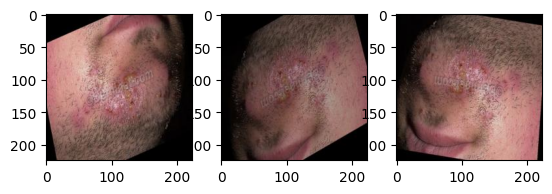

In [21]:
# Querying
import matplotlib.pyplot as plt
query = "I have painful, red pustules on my beard"
limit = 3
query_embedding = align_text(query).flatten().tolist()

search_result_text = client.search(
    collection_name=collection_name, 
    query_vector=query_embedding, 
    query_filter=Filter(
        must=[FieldCondition(key="type", match=MatchValue(value="text"))]
    ),
    with_payload=True,
    limit=limit
)

for result in search_result_text:
    print(result.payload["original_text"])

search_result_image = client.search(
    collection_name=collection_name, 
    query_vector=query_embedding, 
    query_filter=Filter(
        must=[FieldCondition(key="type", match=MatchValue(value="image"))]
    ),
    with_payload=True,
    limit=limit
)

i = 0
for result in search_result_image:
    image_path = result.payload["image_path"]
    print(image_path)
    image = Image.open(image_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    i += 1

plt.show()